# ВЫПУСКНОЙ ПРОЕКТ

"Мы жаждем увидеть в своем составе крутого аналитика, который возьмет огромное количетво наших данных и сотворит из них чудо. Конкретнее про чудо: наши пользователи совершают много действий в приложении, и мы уверены, что в этих данных есть инсайты, которые позволят нам стать лучшим приложением для продажи ненужных вещей. "Ненужные вещие" - ваши ненужные вещи нужны кому-то другому!"

**Задача:** выделение групп пользователей на основе поведения.

У нас есть два дата сета с данными. Будем двигаться по следующему плану:
1. Выгрузка данных
2.  Предобработка данных:
    2.1. Переименование столбцов,
    2.2. Изменение типов данных,
    2.3. Поиск пропущенных значений,
    2.4. Изучение уникальных значений в столбцах,
    2.5. Поиск дубликатов.
3. Анализ общего поведения пользователей:
    3.1. Время, проведенное в приложении,
    3.2. Частота пользования приложением,
    3.3. Retention rate,
    3.4. Конверсия.
4. Сегментация:
    4.1. Лучшие по retention rate,
    4.2. Лучшие по конверсии.
5. Проверка гипотез:
    5.1. Некоторые пользователи установили приложение по ссылке из yandex, другие - из google. Гипотеза №1: две эти группы демонстрируют разную конверсию в просмотры контактов.
    5.2. Гипотеза №2: пользователи, посмотревшие фотографии в объявлении, показывают конверсию в целевое дейсттвие выше, чем те, которые не посмотрели.

### Выгрузка данных

In [1]:
import pandas as pd #импортируем все необходимые библиотеки
import numpy as np
import seaborn as sns
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
import math as mth
import matplotlib as mpl
from scipy import stats as st
from datetime import datetime, timedelta
pd.set_option('display.float_format', '{:.2f}'.format) #для округления цифр до 2-х знаков после запятой
mpl.style.use(['seaborn-dark-palette'])

Откроем файлы

In [2]:
try:
    data = pd.read_csv('/Users/evgeniyakoreshilova/Downloads/mobile_dataset.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
data.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [3]:
try:
    sources = pd.read_csv('/Users/evgeniyakoreshilova/Downloads/123.csv')
except:
    sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv')
sources.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


### Предобработка данных

Посмотрим на общую информацию

In [4]:
display(data.info())
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


Переименуем столбцы

In [5]:
data.columns = ['event_time', 'event_name', 'user_id']
sources = sources.rename(columns={'userId' : 'user_id'})

Посмотрим на уникальные имена в столбце событий

In [6]:
data['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Заменим содержимое в столбце событий

In [7]:
data = data.replace('show_contacts', 'contacts_show')
data = data.replace(['search_4', 'search_5', 'search_1',
                                     'search_3', 'search_6', 'search_7', 'search_2'], 'search')

Пропущенных значений нет, посмотрим на дубликаты

In [8]:
display(data.duplicated().sum())
sources.duplicated().sum()

0

0

Столбец с датой приведем к нужному типу данных и округлим до секунд. Также добавим столбец, в котором укажем только дату

In [9]:
data['event_time'] = pd.to_datetime(data['event_time'], format='%Y-%m-%d %H:%M:%S').dt.round('1S')
data['date'] = pd.to_datetime(data['event_time']).dt.date

Объединим таблицы

In [10]:
data_sources = data.merge(sources, on='user_id', how='left')
data_sources = data_sources.sort_values(by=['user_id', 'event_time']) #отсортируем датасет по дате и по пользователям

**Вывод:** в ходе предобработки данных мы переименовали столбцы и привели столбец с датой к нужному типу. Дубликаты и пропущенные значения отсутствуют. Для дальнейшего анализа мы объединила два исходных датасета по столбцу 'user_id'.

### Анализ общего поведения пользователей

#### Частота пользования приложением

Посмотрим какие события совершали пользователи

In [11]:
data_sources['event_name'].unique()

array(['tips_show', 'map', 'search', 'photos_show', 'favorites_add',
       'contacts_show', 'contacts_call', 'advert_open', 'tips_click'],
      dtype=object)

События не представляют собой последовательности. Переход к целевому действию может быть совершен практически из любого действия

Посмотрим, сколько событий совершили пользователи

In [12]:
data_sources_events = data_sources.groupby('event_name')['user_id'].count()\
    .reset_index().sort_values('user_id', ascending=False)
data_sources_events

,event_name,user_id
8,tips_show,40055
5,photos_show,10012
6,search,6784
0,advert_open,6164
2,contacts_show,4529
4,map,3881
3,favorites_add,1417
7,tips_click,814
1,contacts_call,541


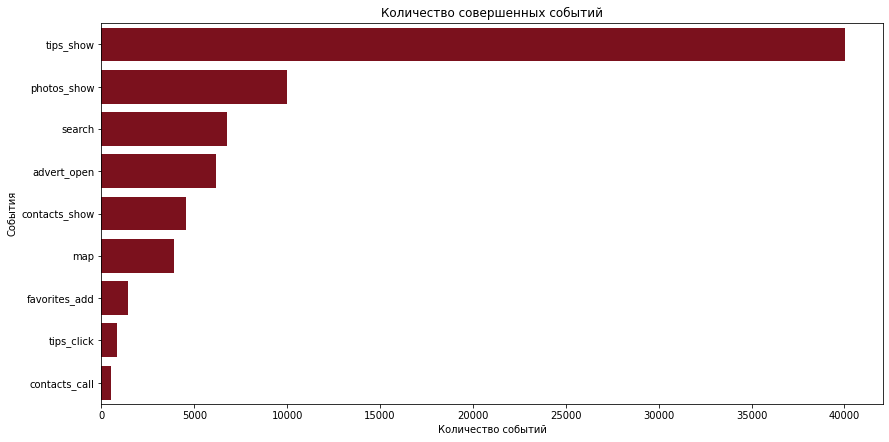

In [13]:
plt.figure(figsize=(14, 7))

x = data_sources_events['event_name']
y = data_sources_events['user_id']
sns.barplot(
    x = y, 
    y = x, 
    data=data_sources_events,  
    color='#8C000F'
).set(title="Количество совершенных событий", xlabel='Количество событий', ylabel='События')
plt.show()

Самым популярным событием является - просмотр рекомендаций. Посмотрим, как события распределены по дням

<function matplotlib.pyplot.show(close=None, block=None)>

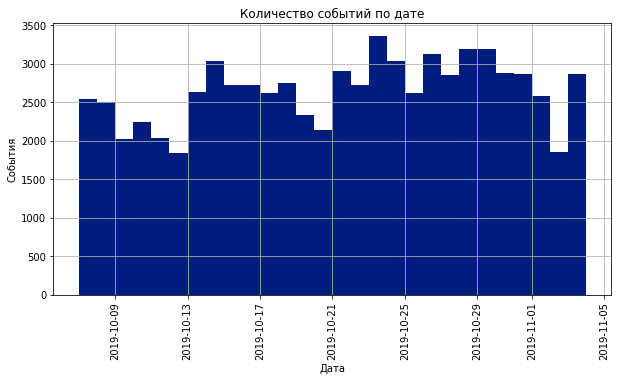

In [14]:
data_sources['event_time'].hist(figsize=(10, 5), bins=28)
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('События')
plt.title('Количество событий по дате')
plt.show

Сильных провалов, как и сильных всплесков не наблюдается. 13 октября это воскресенье, значит можно предположить, что с началом недели спрос на просмотр объявлений поднимается, к концу недели падает.

Посмотрим, сколько пользователей совершили хотя бы одно событие

In [15]:
data_sources_grouped2 = data_sources.groupby('event_name')['user_id'].nunique()\
    .reset_index().sort_values('user_id', ascending=False)
data_sources_grouped2

,event_name,user_id
8,tips_show,2801
6,search,1666
4,map,1456
5,photos_show,1095
2,contacts_show,981
0,advert_open,751
3,favorites_add,351
7,tips_click,322
1,contacts_call,213


Вычислим долю пользователей, совершивших эти события

In [16]:
data_sources_grouped2['percent'] = data_sources_grouped2['user_id'] / data_sources['user_id'].nunique()*100
data_sources_grouped2 

,event_name,user_id,percent
8,tips_show,2801,65.25
6,search,1666,38.81
4,map,1456,33.92
5,photos_show,1095,25.51
2,contacts_show,981,22.85
0,advert_open,751,17.49
3,favorites_add,351,8.18
7,tips_click,322,7.50
1,contacts_call,213,4.96


Почти 23% пользователей совершили целевое действие. 65% - это просмотр рекомендованных объявлений

Посмотрим, сколько дней пользовались приложением

In [17]:
data_sources_time = data_sources.groupby(['user_id'])['date'].nunique().reset_index()\
            .sort_values(by='date', ascending = False)
data_sources_time

,user_id,date
615,21230dd9-2f7f-4b77-a436-43d4d10388e0,25
2103,7e797355-265c-4997-ba47-2258e06d3c66,21
235,0d9e5bb7-0ad6-4b62-a118-b1e4f5b31dfa,21
401,1580911b-65db-4f1a-be7e-1ca39becac30,18
1668,6383ff6a-04b8-4562-a98f-bb4f760d3c39,18
...,...,...
2368,8bf8f713-99bb-408e-ac73-fdc1b2357e30,1
2369,8c227867-4ed5-457d-a7d2-bb0e5b7374d4,1
2370,8c24ccb9-5f01-49c8-b8f3-da3319e3dc59,1
1003,3a9e494e-2cfa-4746-bb7d-659b177c986f,1


In [18]:
data_sources_time = data_sources.groupby(['user_id'])['date'].nunique().reset_index()\
            .sort_values(by='date', ascending = False)
data_sources_time

,user_id,date
615,21230dd9-2f7f-4b77-a436-43d4d10388e0,25
2103,7e797355-265c-4997-ba47-2258e06d3c66,21
235,0d9e5bb7-0ad6-4b62-a118-b1e4f5b31dfa,21
401,1580911b-65db-4f1a-be7e-1ca39becac30,18
1668,6383ff6a-04b8-4562-a98f-bb4f760d3c39,18
...,...,...
2368,8bf8f713-99bb-408e-ac73-fdc1b2357e30,1
2369,8c227867-4ed5-457d-a7d2-bb0e5b7374d4,1
2370,8c24ccb9-5f01-49c8-b8f3-da3319e3dc59,1
1003,3a9e494e-2cfa-4746-bb7d-659b177c986f,1


<function matplotlib.pyplot.show(close=None, block=None)>

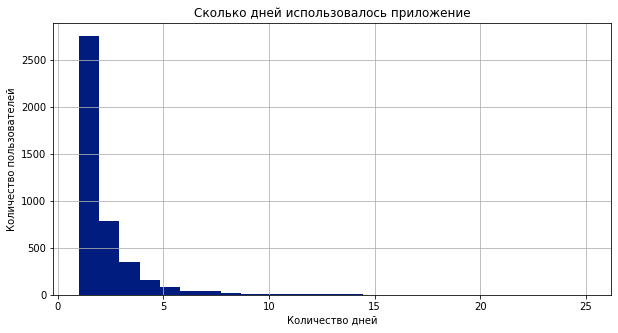

In [19]:
data_sources_time.hist(figsize=(10, 5), bins=25)
plt.xlabel('Количество дней')
plt.ylabel('Количество пользователей')
plt.title('Сколько дней использовалось приложение')
plt.show

In [20]:
data_sources_time.describe()

,date
count,4293.00
mean,1.82
std,1.76
min,1.00
25%,1.00
50%,1.00
75%,2.00
max,25.00


**Вывод:** 
Среднее время, в которое пользовались приложением - 1.75 дня за период с 7 октября по 4 ноября 2019 года. Минимальное время и медианное - 1 день. Свыше 3 дней приложение используют единичные пользователи. Возможно активные продавцы.

#### Время, проведенное в приложении

Так как в датафрейме отсутствует логирование сессий, возьмем за одну сессию - 1 календарный день.
Посчитаем продолжительность сессий пользователей, для этого найдем минимальное и максимальное время в течение дня.

In [21]:
# Добавим еще один столбец со временем, чтобы найти минимум и максимум для каждого пользователя в течение дня
data_sources['event_time2'] = data_sources['event_time']

In [22]:
data_session = (
    data_sources.groupby(['user_id', 'date'])
    .agg({'event_time' : 'min', 'event_time2' : 'max'}).reset_index()
    .rename(columns={'event_time' : 'min','event_time2' : 'max',})
)

In [23]:
data_sources = data_sources.drop(columns=['event_time2'])

In [24]:
#рассчитаем продолжительность сессий в минутах
data_session['sessions_min'] = (data_session['max'] - data_session['min']).dt.total_seconds()/60
data_session.sort_values(by='sessions_min')

,user_id,date,min,max,sessions_min
3908,7fd86321-b287-42aa-96f8-b7601e2ae3de,2019-10-27,2019-10-27 12:22:41,2019-10-27 12:22:41,0.00
1788,38e01536-3db6-4d48-944e-bb224db6b315,2019-10-24,2019-10-24 09:00:00,2019-10-24 09:00:00,0.00
1784,38e01536-3db6-4d48-944e-bb224db6b315,2019-10-17,2019-10-17 23:09:05,2019-10-17 23:09:05,0.00
1777,38b05b59-fcf0-4eb9-a8af-048cc462b2f7,2019-10-22,2019-10-22 08:25:51,2019-10-22 08:25:51,0.00
5599,b8851327-dde7-4913-a61c-1735aa9ecb77,2019-10-19,2019-10-19 17:00:03,2019-10-19 17:00:03,0.00
...,...,...,...,...,...
7247,ece5976a-373d-4268-b9b7-89a96ad8c7ad,2019-10-27,2019-10-27 00:59:36,2019-10-27 23:59:38,1380.03
5531,b64f59df-42e3-4d7d-81ca-4dd74af183c0,2019-10-28,2019-10-28 00:02:03,2019-10-28 23:08:16,1386.22
6144,c9c31c08-5b88-43cf-aa2a-45aefb7ecbcf,2019-10-21,2019-10-21 00:28:20,2019-10-21 23:55:26,1407.10
5663,bb075fc6-a988-48b3-af86-15385011f40d,2019-10-14,2019-10-14 00:21:35,2019-10-14 23:52:18,1410.72


Построим график, посмотрим как распределяются продолжительности сессий среди пользователей

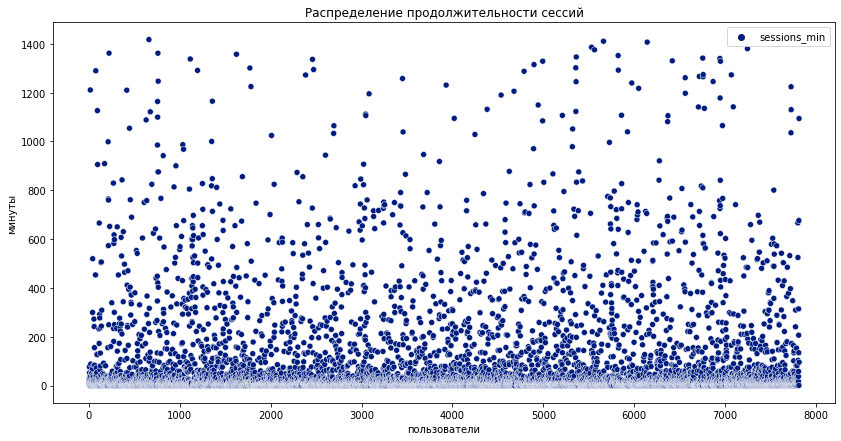

In [25]:
plt.figure(figsize=(14, 7))
sns.scatterplot(data=data_session)\
.set(title="Распределение продолжительности сессий", xlabel='пользователи', ylabel='минуты')
plt.show()

В основном, продолжительность сессии не превышает 100 минут, но есть много нулевых сессий, а также аномально длинных сессий свыше 1400 минут. Посмотрим на продолжительность всех сессий в разрезе пользователей

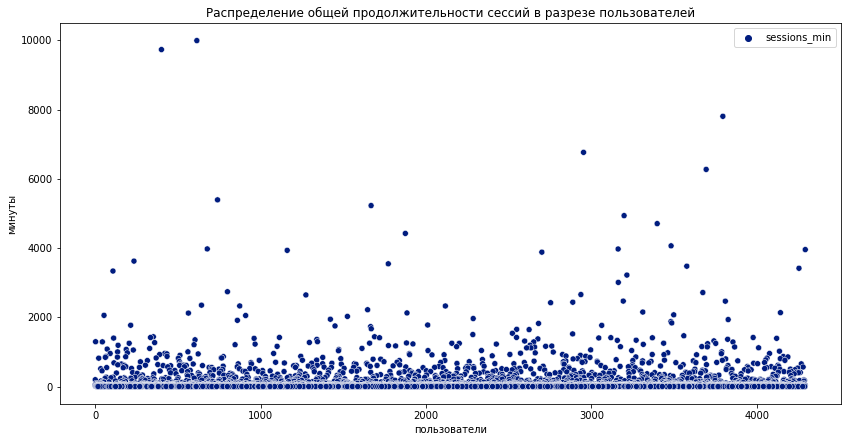

In [26]:
data_session2 = data_session.groupby('user_id').agg({'sessions_min' : 'sum'}).reset_index()\
                .sort_values(by = 'sessions_min', ascending=False)
plt.figure(figsize=(14, 7))
sns.scatterplot(data=data_session2)\
.set(title="Распределение общей продолжительности сессий в разрезе пользователей",\
     xlabel='пользователи', ylabel='минуты')
plt.show()

Удалим пользователей, чья общая продолжительность сессий составляет более 2000 минут.

In [27]:
data_session2 = data_session2.query('sessions_min < 2000')
data_session = data_session.query('user_id in @data_session2["user_id"]')
data_sources = data_sources.query('user_id in @data_session2["user_id"]')

Посмотрим, сколько уникальных пользователей мы удалили.

In [28]:
data['user_id'].nunique() - data_sources['user_id'].nunique()

43

In [29]:
(data['user_id'].nunique() - data_sources['user_id'].nunique())/data['user_id'].nunique()*100

1.001630561378989

In [30]:
data_session.describe()

,sessions_min
count,7337.00
mean,66.78
std,158.59
min,0.00
25%,2.33
50%,11.15
75%,41.35
max,1417.48


После удаления 1% пользователей, которые провели в приложении аномально длинное время, все равно данные по сессиям нельзя назвать корректными. Осталось много аномально длинных сессий, но в условиях отсутствия логирования сессий - оставим данные такими.

Посмотрим на продолжительность всех сессий в течение дня

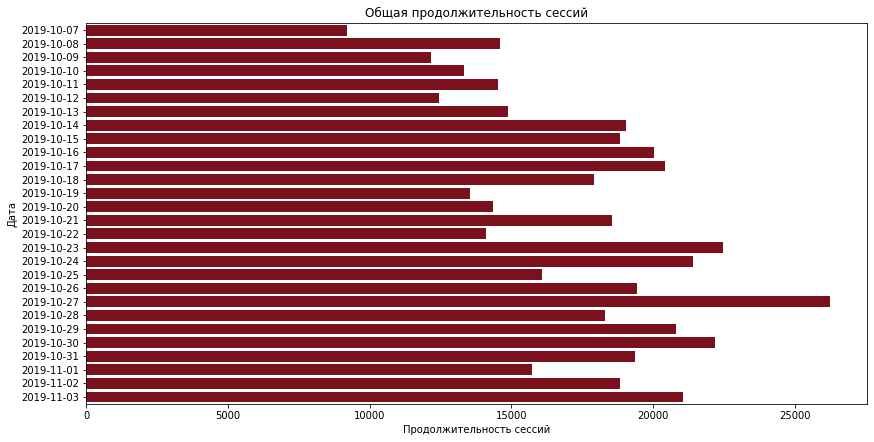

In [31]:
data_session_grouped = data_session.groupby('date')['sessions_min'].sum().reset_index()
plt.figure(figsize=(14, 7))

x = data_session_grouped['date']
y = data_session_grouped['sessions_min']
sns.barplot(
    x = y, 
    y = x, 
    data=data_session_grouped,  
    color='#8C000F'
).set(title="Общая продолжительность сессий", xlabel='Продолжительность сессий', ylabel='Дата')
plt.show()

27 октября 2019 года день, когда продолжительность всех сессий была самой большой. Это воскресенье. В остальном, здесь также наблюдается спад продолжительности сессий в выходные дни и рост - в будни. 

Узнаем также, сколько в среднем событий приходится на 1 пользователя

In [32]:
(data_sources['event_name'].count()) / (data_sources['user_id'].nunique())

15.986117647058823

**Вывод:** за период с 7 октября по 4 ноября 2019 года среднее время, в которое пользовались приложением - 1.75 дня. Минимальное время и медианное - 1 день. Свыше 3 дней приложение использовали единичные пользователи. В основном, продолжительность сессии в день не превышала 100 минут, но есть много нулевых сессий, а также аномально длинных сессий свыше 1400 минут. В ходе анализа нами был удален 1% пользователей, которые провели в приложении в указанный период свыше 2000 минут.

#### Retention rate

Посчитаем Retention rate. Момент анализа - 4 ноября 2019 года, последняя дата в датасете. За горизонт анализа примем 10 дней.

In [33]:
#найдем дату появления пользователя в приложении
data_sources_min = data_sources.groupby('user_id').agg({'date' : 'min'}).reset_index()
data_sources_min.columns = ['user_id', 'start']

In [34]:
def get_retention(
    data_sources, data_sources_min, observation_date, horizon_days, ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    

    # собираем «сырые» данные для расчёта удержания
    data_sources_raw = data_sources.merge(data_sources_min, on='user_id', how='left')
    
    data_sources_raw['lifetime'] = (
    data_sources_raw['date'] - data_sources_raw['start']
).dt.days

    data_sources_raw = data_sources_raw.query('start <= @last_suitable_acquisition_date')
    
    # рассчитываем удержание
    data_sources_grouped = data_sources_raw.pivot_table(
        index=['start'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        data_sources_raw.groupby('start')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    data_sources_grouped = cohort_sizes.merge(
        data_sources_grouped, on='start', how='left'
    ).fillna(0)
    data_sources_grouped = data_sources_grouped.div(data_sources_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    data_sources_grouped = data_sources_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    #восстанавливаем столбец с размерами когорт
    data_sources_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return data_sources_raw, data_sources_grouped

In [35]:
data_sources_raw, data_sources_grouped = get_retention(
    data_sources, data_sources_min, datetime(2019, 11, 4).date(), 10, #ignore_horizon=True
)

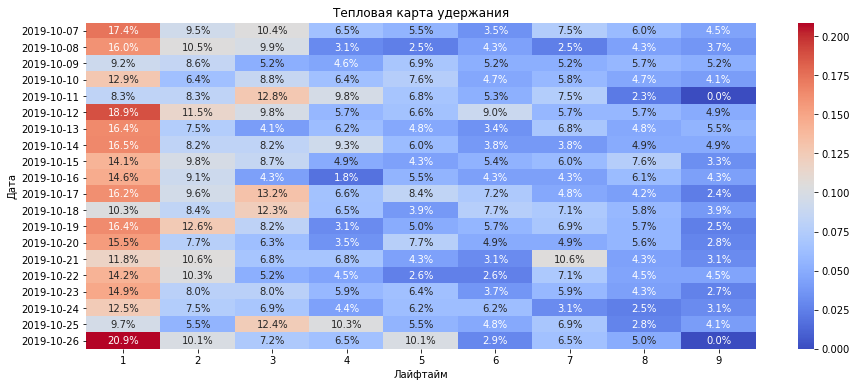

In [36]:
# строим хитмэп без нулевого лайфтайма

plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    data_sources_grouped.drop(columns=['cohort_size', 0]),  # удаляем лишние столбцы
    annot=True,  # включаем подписи
    fmt='.1%',  # переводим значения в проценты
    cmap="coolwarm"
).set(xlabel='Лайфтайм', ylabel='Дата')
plt.title('Тепловая карта удержания')  # название графика
plt.show()

Самый высокий процент удержания пользователей от 13.10.2019 - 5.5%. Самые низкие проценты удержания пользователей, пришедших на сайт 11.10 (0%) и 26.10 (0%)                                   

#### Конверсия

Посчитаем конверсию. Момент анализа - 4.11.2019, горизонт анализа - 10 дней

In [37]:
# функция для расчёта конверсии get_conversion()

def get_conversion(
    data_sources,
    data_sources_min,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    data_sources_raw = data_sources.merge(data_sources_min, on='user_id', how='left')
    data_sources_raw = data_sources_raw.query('start <= @last_suitable_acquisition_date')

    # определяем дату и время первого просмотра контактов каждого пользователя
    data_sources_show = data_sources_raw.query('event_name == "contacts_show"').copy()
    first_data_sources_show = (
        data_sources_show.sort_values(by=['user_id', 'date'])
        .groupby('user_id')
        .agg({'date': 'first'})
        .reset_index()
    )
    first_data_sources_show.columns = ['user_id', "first_show"]
    #добавим информацию о первом показе контактов в таблицу
    data_sources_raw = data_sources_raw.merge(first_data_sources_show, on='user_id', how='left')
    

    # рассчитываем лайфтайм для каждого просмотра
    data_sources_show['lifetime'] = (
        data_sources_show['date'] - data_sources_show['start']
    ).dt.days
    
    
    # добавляем лайфтайм в общую таблицу
    data_sources_raw = data_sources_raw.merge(data_sources_show[['user_id', 'lifetime']], on='user_id', how='left')
    
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        data_sources_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
        
        # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(data_sources_raw, dimensions, horizon_days)

        
    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

   
    # возвращаем обе таблицы и сырые данные
    return data_sources_raw, result_grouped
    
    

In [38]:
data_sources_raw_2, data_sources_grouped_2 = get_conversion(
    data_sources, data_sources_min, datetime(2019, 11, 4).date(), 10, dimensions=['start'] #ignore_horizon=True
)


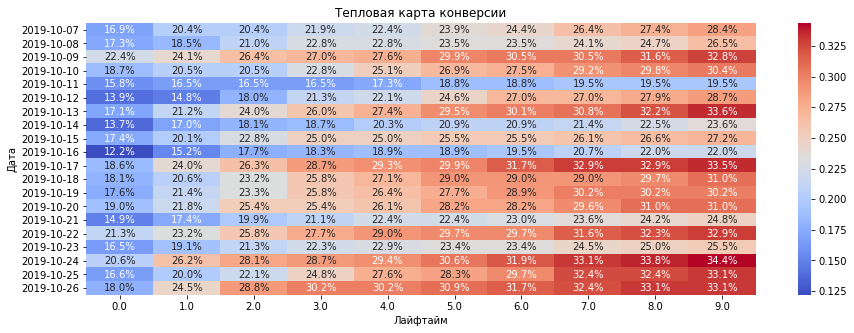

In [39]:
# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 5))
sns.heatmap(data_sources_grouped_2.drop(columns=['cohort_size']), annot=True, fmt='.1%', cmap="coolwarm")\
            .set(xlabel='Лайфтайм', ylabel='Дата')
plt.title('Тепловая карта конверсии')
plt.show() 

Самые высокие показатели конверсии в когорте пользователей от 24.10 (34.4%). Самые низкие показатели у пользователей от 11.10 (19.5%) и от 16.10 (22%).

**Вывод:**
Из 9 событий, совершаемых пользователями, самым популярным является - 'tips_show' - 65% посетителей хотя бы однократно совершили его. Целевое действие - 'contacts_show' - совершили 23% пользователей. В среднем на одного пользователя приходится 16 событий. График распределения событий по дням не показывает сильных провалов и сильных всплесков, но можно предположить, что с началом недели спрос на приложение  поднимается, к концу недели падает. Среднее количество дней в которые использовали приложение составляет 1.75 дня. Минимальное время и медианное - 1 день. Свыше 3 дней приложение использовали единичные пользователи. В основном, продолжительность сессии в день не превышала 100 минут, но есть много нулевых сессий, а также аномально длинных сессий свыше 1400 минут. В ходе анализа нами был удален 1% пользователей, которые провели в приложении в указанный период свыше 2000 минут.

Тепловая карта удержания показала высокие и низкие значения по когортам, а именно: самые вымокие показатели конверсии в когорте пользователей от 24.10 (34.4%). Самые низкие показатели у пользователей от 11.10 (19.5%) и от 16.10 (22%).

Тепловая карта конверсии показала высокие и низкие значения по когортам, а именно: самые высокие показатели в когорте пользователей от 10.10 (34.4%) и от 18.10 (34.16%), самые низкие показатели у пользователей от 08.10 (24%) и от 15.10 (24.7%).

### Сегментация

Разделим пользователей на 2 группы:
- посмотрели фотографии

- не смотрели фотографии

и сравним у них удержание и конверсию

Почему мы выбираем именно такую сегментацию. Потому что важно узнать, какая часть пользователей при просмотре объявлений смотрит фотографии и влияет ли это на решение о совершении целевого действия(в нашем случае - просмотр контактов). Можно предположить, что заинтересованный в "ненужно вещи" пользователь посмотрит фотографии и скорее примет положительное решение в пользу совершения целевого дейсвия, то есть конверсия пользователей, посмотревших фотографии, должна быть выше чем у пользователей, не смотревших их. Провери наши предположения.

Выделим пользователей, которые хотя бы 1 раз открыли карточки с фотографиями

In [40]:
data_sources_photo = data_sources.query('event_name =="photos_show"').copy()
photo_unique = data_sources_photo['user_id'].unique()

Разделим пользователей на тех, кто смотрел фотографии и на тех кто ни разу не смотрел.

In [41]:
data_sources_photo = data_sources.query('user_id in @photo_unique').copy() #смотрели фото
data_sources_photo_not = data_sources.query('user_id not in @photo_unique').copy() #не смотрели фото
data_sources_photo['user_id'].nunique()/data_sources['user_id'].nunique()*100 #%смотрящих фотографии

25.341176470588234

Посмотрим удержание между этими группами

In [42]:
data_sources_photo_raw, data_sources_photo_grouped = get_retention(
    data_sources_photo, data_sources_min, datetime(2019, 11, 4).date(), 10, #ignore_horizon=True
)

In [43]:
data_sources_photo_not_raw, data_sources_photo_not_grouped = get_retention(
    data_sources_photo_not, data_sources_min, datetime(2019, 11, 4).date(), 10, #ignore_horizon=True
)

In [44]:
#data_sources_photo_grouped = data_sources_photo_grouped.reset_index()

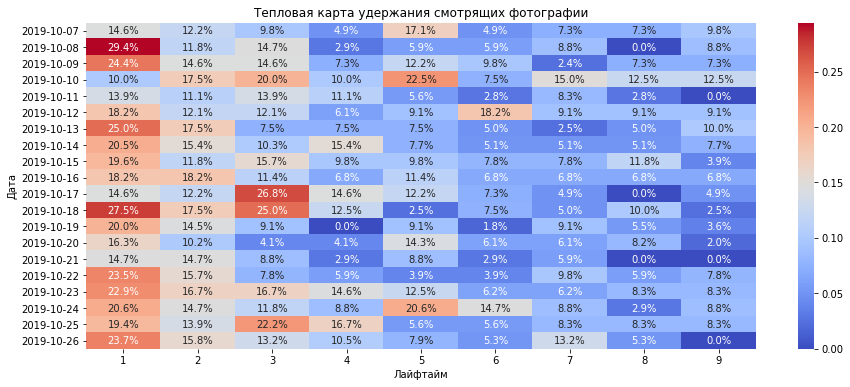

In [45]:
#data_sources_photo_grouped['start'] = data_sources_photo_grouped['start'].dt.strftime('%Y-%m-%dT')

# строим хитмэп без нулевого лайфтайма
plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    data_sources_photo_grouped.drop(columns=['cohort_size', 0]),  # удаляем лишние столбцы
    annot=True,  # включаем подписи
    fmt='.1%',  # переводим значения в проценты
    cmap="coolwarm"
).set(xlabel='Лайфтайм', ylabel='Дата')
plt.title('Тепловая карта удержания смотрящих фотографии')  # название графика
plt.show()

Очень неоднородный график и процент удержания пользователей между когортами на 10 день колеблется  от 0% до 12.5%.

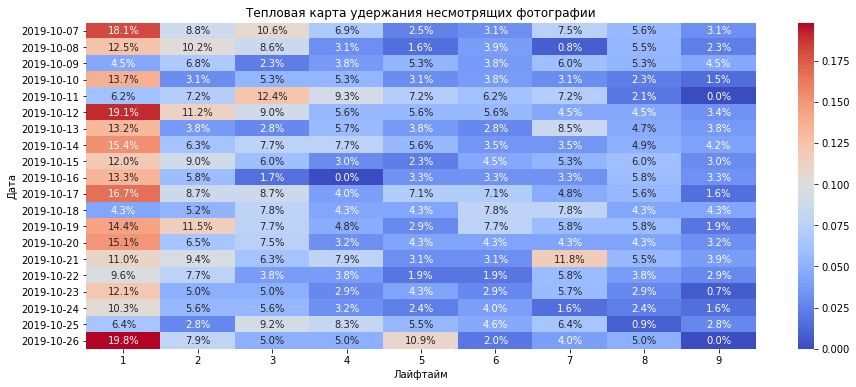

In [46]:
# строим хитмэп без нулевого лайфтайма

plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    data_sources_photo_not_grouped.drop(columns=['cohort_size', 0]),  # удаляем лишние столбцы
    annot=True,  # включаем подписи
    fmt='.1%',  # переводим значения в проценты
    cmap="coolwarm"
).set(xlabel='Лайфтайм', ylabel='Дата')
plt.title('Тепловая карта удержания несмотрящих фотографии')  # название графика
plt.show()

Тепловая карта несмотрящих фотограии более однородна по цвету, показатели удержания уступают группе, смотрящих фотографии. Самый высокий процент - 4.5%

Посмотрим на конверсию в этих группах

In [47]:
data_sources_photo_raw_2, data_sources_photo_grouped_2 = get_conversion(
    data_sources_photo, data_sources_min, datetime(2019, 11, 4).date(), 10, #ignore_horizon=True
)

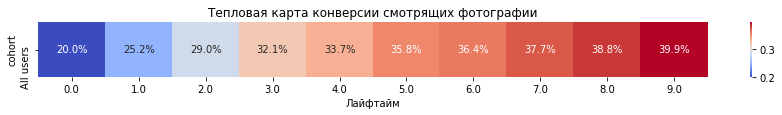

In [48]:
plt.figure(figsize=(15, 1))
sns.heatmap(data_sources_photo_grouped_2.drop(columns=['cohort_size']), annot=True, fmt='.1%', cmap="coolwarm")\
            .set(xlabel='Лайфтайм')
plt.title('Тепловая карта конверсии смотрящих фотографии')
plt.show() 

Процент конверсии пользователей, смотрящих фотографии, - 40%

In [49]:
data_sources_photo_not_raw_2, data_sources_photo_not_grouped_2 = get_conversion(
    data_sources_photo_not, data_sources_min, datetime(2019, 11, 4).date(), 10, #ignore_horizon=True
)

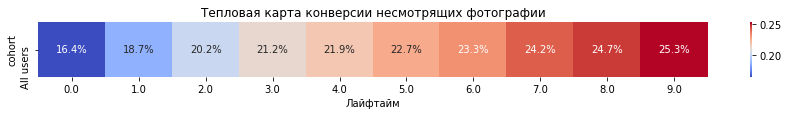

In [50]:
plt.figure(figsize=(15, 1))
sns.heatmap(data_sources_photo_not_grouped_2.drop(columns=['cohort_size']), annot=True, fmt='.1%', cmap="coolwarm")\
            .set(xlabel='Лайфтайм')
plt.title('Тепловая карта конверсии несмотрящих фотографии')
plt.show() 

Процент конверсии пользователей, не смотрящих фотографии - 25%

**Вывод:** для более детального анализа мы разделили пользователей на две группы - тех, кто смотрел фотографии в приложении и тех, кто не смотрел, получилось 25% и 75% соответственно.
Удержание пользователей и конверсия пользователей, которые смотрели фотографии, существенно выше, чем у пользователей во второй группе.

### Проверка гипотез

#### Некоторые пользователи установили приложение по ссылке из yandex, другие - из google. Гипотеза №1: две эти группы демонстрируют разную конверсию в просмотры контактов.

разделим пользователей на две группы

In [51]:
data_sources_yandex = data_sources.query('source == "yandex"')['user_id'].nunique() #yandex
data_sources_google = data_sources.query('source == "google"')['user_id'].nunique() #google

Посмотрим, есть ли пересечения в группах

In [52]:
data_sources.groupby('user_id')['source'].nunique().reset_index().sort_values(by='source', ascending = False)

,user_id,source
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1
2838,aa6f9849-52e1-417f-bf9f-d0bcb7d030fa,1
2824,a9c5dc9b-ec2c-43bb-b0ad-0fe98c27e9c7,1
2825,a9ce2005-b88a-4662-aa00-63d6d9dc58a1,1
2826,a9ea8fd1-1e54-401e-b5b0-a4347a699519,1
...,...,...
1422,55f7dc86-a03b-4cff-adc6-61a23d4ab680,1
1423,560c8359-cd10-4ad7-bf0d-88259d0bc5b4,1
1424,561aef05-49b7-4aa6-b990-8478cb62f0a0,1
1425,5622bed3-de57-4e44-851a-89cb6a2e7596,1


Пересечений нет. Можно приступать к тесту.

Проведем тест "Проверка гипотезы о равенстве долей" - z-тест.

Сформулируем гипотезы:

- Н0: доли пользователей, совершивших событие "просмотр контактов", равны в группах yandex и google
- Н1: доли пользователей, совершивших событие "просмотр контактов", не равны в группах yandex и google

Выберем уровень статистической значимости = 0.05. Учитывая, что проверять гипотезы мы будем неодноратно, то нужно применить поправку Бонферрони, чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, а именно - разделить уровень статистической значимости на количество проводимых тестов, то есть на 2. И в ходе тестирования будем использовать уровень статистической значимости = 0.05/2

Посмотрим сколько пользователей совершили целевое действие - просмотр контактов в каждой из групп

In [53]:
data_sources_yandex_call = (
    data_sources.query('event_name == "contacts_show" and source == "yandex"')['user_id'].nunique()
)

In [54]:
data_sources_google_call = (
    data_sources.query('event_name == "contacts_show" and source == "google"')['user_id'].nunique()
)

In [55]:
def stat (g1, g2, e1, e2):
    alpha = 0.05/2

    events = np.array([e1, e2])
    groups = np.array([g1, g2])

    p1 = events[0]/groups[0] 
    p2 = events[1]/groups[1]
    
    print(events[0], events[1], groups[0] ,groups[1] )

    p_combined = (events[0] + events[1])/(groups[0] + groups[1])
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/groups[0] + 1/groups[1]))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
stat(data_sources_yandex, data_sources_google, data_sources_yandex_call, data_sources_google_call)

471 263 1920 1110
p-значение:  0.6041388573887498
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Гипотеза №2: пользователи, посмотревшие фотографии в объявлении, показывают конверсию в целевое действие выше, чем те, которые не посмотрели.

Посмотрим, сколько пользователей, смотрящих фотографии и несмотрящих фотографии, совершили целевое действие - "просмотр контактов"

In [56]:
data_sources_photo_call = data_sources_photo.query('event_name == "contacts_show"')['user_id'].nunique()
data_sources_photo_not_call = data_sources_photo_not.query('event_name == "contacts_show"')['user_id'].nunique()

In [57]:
data_sources_photo_group = data_sources_photo['user_id'].nunique()
data_sources_photo_not_group = data_sources_photo_not['user_id'].nunique()

Проверим пользователей на пересечение в группах

In [58]:
data_sources['user_id'].nunique() - (data_sources_photo_group + data_sources_photo_not_group)

0

Пересечений нет, можно приступать к тесту

Сформулируем гипотезы:

- Н0: доли пользователей, совершивших событие "просмотр контактов", равны в группах смотревших фото и несмотревших фото
- Н1: доли пользователей, совершивших событие "просмотр контактов", не равны в группах смотревших фото и несмотревших фото

In [59]:
stat(data_sources_photo_group, data_sources_photo_not_group, data_sources_photo_call, data_sources_photo_not_call)

327 629 1077 3173
p-значение:  8.246736626915663e-13
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Вывод:** В ходе проверки гипотез было установлено, что между группами яндекс и гугл нет статистически значимой разницы. Между группами смотревших и несмотревших фото - разница есть.

**Общий вывод:**
С двумя полученными датасетами мы проделали большую работу. В ходе предобработки данных мы переименовали столбцы и привели их к нужному типу, затем объединили два фреймтайма в один.
    
Посчитали, что пользователи в приложении совершают 9 событий. Самым популярным из них является - 'tips_show' - 65% посетителей хотя бы однократно совершили его. Целевое действие - 'contacts_show' - совершили 23% пользователей. В среднем на одного пользователя приходится 16 событий. График распределения событий по дням не показывает сильных провалов и сильных всплесков, но можно предположить, что с началом недели спрос на приложение поднимается, к концу недели падает. Среднее количество дней в которые использовали приложение составляет 1.75 дня. Минимальное время и медианное - 1 день. Свыше 3 дней приложение использовали единичные пользователи. В основном, продолжительность сессии в день не превышала 100 минут, но есть много нулевых сессий, а также аномально длинных сессий свыше 1400 минут. В ходе анализа нами был удален 1% пользователей, которые провели в приложении в указанный период свыше 2000 минут.


Тепловая карта удержания показала высокие и низкие значения по когортам, а именно: самые вымокие показатели конверсии в когорте пользователей от 24.10 (34.4%). Самые низкие показатели у пользователей от 11.10 (19.5%) и от 16.10 (22%).

Тепловая карта конверсии показала высокие и низкие значения по когортам, а именно: самые высокие показатели в когорте пользователей от 10.10 (34.4%) и от 18.10 (34.16%), самые низкие показатели у пользователей от 08.10 (24%) и от 15.10 (24.7%).


Далее, для более детального анализа мы разделили пользователей на две группы - тех, кто смотрел фотографии в приложении и тех, кто не смотрел, получилось 25% и 75% соответственно.
Удержание пользователей и конверсия пользователей, которые смотрели фотографии, существенно выше, чем у пользователей во второй группе. Удержание 12% против 6%, конверсия 40% против 25%.

В ходе проверки гипотез на наличие разницы в конверсии в целевое действие было установлено, что между группами яндекс и гугл нет статистически значимой разницы. Между группами смотревших и несмотревших фото - разница есть. Следовательно, при дальнейшей разработке приложения следует учитывать, что просмотр фотографии в объявлении повышает вероятность целевого действия - просмотр контактов.



